In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
import json


data_path = "data/NPD_Data_2018_2019_V3.csv"
npd_data = pd.read_csv(data_path)

In [8]:
clean_data = npd_data.dropna()

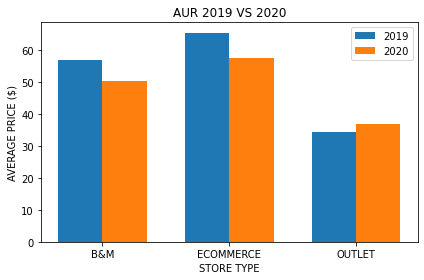

In [37]:
nineteen = clean_data[clean_data["Year"]==2019]
twenty = clean_data[clean_data["Year"]==2020]

nineteen_clothes = nineteen[(nineteen['Category'] == 'PANT/CAPRI') | (nineteen['Category'] == 'JACKET/VEST')]
twenty_clothes = twenty[(twenty['Category'] == 'PANT/CAPRI') | (twenty['Category'] == 'JACKET/VEST')]

nineteen_clothes['TY AUR'] = nineteen_clothes['TY AUR'].astype(float)
twenty_clothes['TY AUR'] = twenty_clothes['TY AUR'].astype(float)

nineteen_stores = round(nineteen_clothes.groupby(['StoreType']).mean(),2)
twenty_stores = round(twenty_clothes.groupby(['StoreType']).mean(),2)

store_type_aur = pd.concat([nineteen_stores, twenty_stores])

labels = ['B&M', 'ECOMMERCE', 'OUTLET']
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nineteen_stores["TY AUR"], width, label='2019')
rects2 = ax.bar(x + width/2, twenty_stores["TY AUR"], width, label='2020')


ax.set_title('AUR 2019 VS 2020')
ax.set_ylabel('AVERAGE PRICE ($)')
ax.set_xlabel('STORE TYPE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
pd.set_option('mode.chained_assignment', None)
fig.tight_layout()

plt.show()

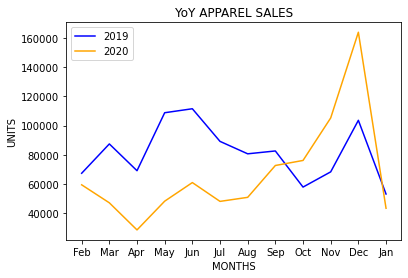

In [38]:
nineteen_clothes['Units'] = nineteen_clothes['Units'].str.replace(',', '').astype(float)
twenty_clothes['Units'] = twenty_clothes['Units'].str.replace(',', '').astype(float)

a = nineteen_clothes.groupby(['Month'],sort = False).sum()
b = twenty_clothes.groupby(['Month'], sort = False).sum()

plt.plot(a["Units"],color="blue")
plt.plot(b["Units"],color="orange")

pd.set_option('mode.chained_assignment', None)
plt.title("YoY APPAREL SALES")
plt.xlabel("MONTHS")
plt.ylabel("UNITS")
plt.legend(["2019","2020"])
plt.show()